In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from crop import crop
import tensorflow as tf
import keras
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
def createModel():
    model = Sequential()

    # The first layer with 128 filters of window size 5x5
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    # The second layer with 256 filters of window size 3x3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    # The  with 384 filters of window size 3x3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(5120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

# Generating Data Set (Original uncompressed images and 3x3 Median filtered images)

In [ ]:
data_x_pos = np.zeros((1338*6, 64, 64, 1))
data_x_neg = np.zeros((1338*6, 64, 64, 1))
data_y = np.concatenate((np.ones((1338*6, 1)), np.zeros((1338*6, 1))))

# Positive Data
os.chdir('/mnt/drive2/msc_2020/ucid.v2')
for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.tif'
    I = cv2.imread(name, 0)
    np.clip(I, 0, 255, out=I)
    I.astype('uint8')
    I = cv2.medianBlur(I, 3)          # MP3 filtered data
    I = cv2.medianBlur(I, 3) - I      # MFR-filter layer
    if I.shape == (512, 384):
        I = I.T
    for j in range(6):
        I_crop = crop(I, j)
        I_crop = I_crop.reshape(64, 64, 1)
        I_crop.astype('float32')
        data_x_pos[6*(i-1)+j,:,:,:] = I_crop

# Negative Data
os.chdir('/mnt/drive2/msc_2020/ucid.v2')#/images')
for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.tif'
    I = cv2.imread(name, 0)
    np.clip(I, 0, 255, out=I)
    I.astype('uint8')
    I = cv2.medianBlur(I, 5) - I
    if I.shape == (512, 384):
        I = I.T
    for j in range(6):
        I_crop = crop(I, j)
        I_crop = I_crop.reshape(64, 64, 1)
        I_crop.astype('float32')
        data_x_neg[6*(i-1)+j,:,:,:] = I_crop

# Combining data and Normalising
data_x = np.concatenate((data_x_pos, data_x_neg), axis=0)
data_x /= 255

# Randomly Shuffling the data
data_x, data_y = shuffle(data_x, data_y, random_state=0)


# Dividing data into traing data and testing data
train_x = data_x[:8028]
train_y = data_y[:8028]

test_x = data_x[8028:]
test_y = data_y[8028:]

# One-hot-vector Representation
train_labels_one_hot = to_categorical(train_y)
test_labels_one_hot = to_categorical(test_y)

In [ ]:
input_shape = (64, 64, 1)
OMF3_model = createModel()
batch_size = 256
epochs = 50
OMF3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
history = OMF3_model.fit(train_x, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1,
                   validation_data=(test_x, test_labels_one_hot))

Epoch 1/50
32/32 [==============================] - 6s 177ms/step - loss: 117.4988 - accuracy: 0.5715 - val_loss: 1.1507 - val_accuracy: 0.5041
Epoch 2/50
32/32 [==============================] - 5s 151ms/step - loss: 0.8054 - accuracy: 0.5638 - val_loss: 0.6770 - val_accuracy: 0.9268
Epoch 3/50
32/32 [==============================] - 5s 151ms/step - loss: 1.3843 - accuracy: 0.7255 - val_loss: 0.4329 - val_accuracy: 0.8621
Epoch 4/50
32/32 [==============================] - 5s 152ms/step - loss: 0.7382 - accuracy: 0.7783 - val_loss: 0.6499 - val_accuracy: 0.5859
Epoch 5/50
32/32 [==============================] - 5s 151ms/step - loss: 0.4054 - accuracy: 0.8614 - val_loss: 0.1956 - val_accuracy: 0.9481
Epoch 6/50
32/32 [==============================] - 5s 154ms/step - loss: 0.5229 - accuracy: 0.8087 - val_loss: 0.1479 - val_accuracy: 0.9518
Epoch 7/50
32/32 [==============================] - 5s 156ms/step - loss: 0.2167 - accuracy: 0.9279 - val_loss: 0.1424 - val_accuracy: 0.9624
Epoc

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

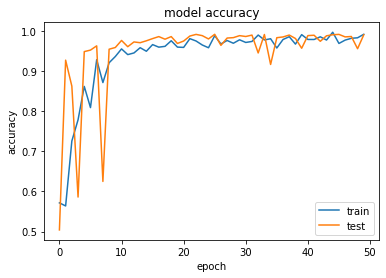

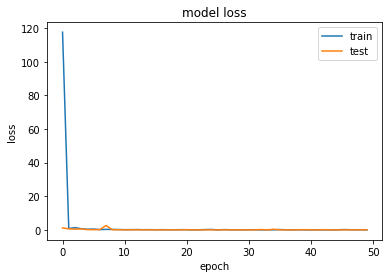

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
OMF3_model.evaluate(test_x, test_labels_one_hot)

251/251 [==============================] - 3s 10ms/step - loss: 0.0529 - accuracy: 0.9899


[0.052863165736198425, 0.9899103045463562]

https://youtu.be/qFJeN9V1ZsI?t=3124 Impliment this

In [ ]:
OMF3_model.save('/mnt/drive2/msc_2020/Convlutional Neural Network/models/OMF3_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /mnt/drive2/msc_2020/Convlutional Neural Network/assets


https://youtu.be/qFJeN9V1ZsI?t=3182 To save the model

https://youtu.be/qFJeN9V1ZsI?t=4298


In [ ]:
# OMF3_model = load_model('/mnt/drive2/msc_2020/Convlutional Neural Network/models/OMF3_model', compile=True)
OMF3_model = load_model('./', compile=True)

ValueError: ignored

[0., 1.] means median filtered images
[1., 0.] means non median filtered images

In [ ]:
# Manual Prediction

os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')

I = cv2.imread('Lena.tiff', 0)
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I
I = I[256-32:256+32, 256-32:256+32]
I = I.reshape(1, 64, 64, 1)


plt.imshow(cv2.medianBlur(cv2.imread('Lena.tiff', cv2.IMREAD_GRAYSCALE ), 3))
if (model.predict(I))[0][0] == 0:
    print('Positive')
else:
    print('Negative')

NameError: name 'os' is not defined

# Generating Data Set (JPEG 70 compressed images and 3x3 Median filtered images)

In [ ]:
data_x_pos = np.zeros((1338*6, 64, 64, 1))
data_x_neg = np.zeros((1338*6, 64, 64, 1))
data_y = np.concatenate((np.ones((1338*6, 1)), np.zeros((1338*6, 1))))

# Positive Data
os.chdir('/mnt/drive2/msc_2020/ucid.v2/images_jpeg70')
for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.jpeg'
    I = cv2.imread(name, 0)
    np.clip(I, 0, 255, out=I)
    I.astype('uint8')
    I = cv2.medianBlur(I, 3)          # MP3 filtered data
    I = cv2.medianBlur(I, 3) - I      # MFR-filter layer
    if I.shape == (512, 384):
        I = I.T
    for j in range(6):
        I_crop = crop(I, j)
        I_crop = I_crop.reshape(64, 64, 1)
        I_crop.astype('float32')
        data_x_pos[6*(i-1)+j,:,:,:] = I_crop

# Negative Data
os.chdir('/mnt/drive2/msc_2020/ucid.v2/images_jpeg70')
for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.jpeg'
    I = cv2.imread(name, 0)
    np.clip(I, 0, 255, out=I)
    I.astype('uint8')
    I = cv2.medianBlur(I, 5) - I          # MFR-filter layer
    if I.shape == (512, 384):
        I = I.T
    for j in range(6):
        I_crop = crop(I, j)
        I_crop = I_crop.reshape(64, 64, 1)
        I_crop.astype('float32')
        data_x_neg[6*(i-1)+j,:,:,:] = I_crop

# Combining data and Normalising
data_x = np.concatenate((data_x_pos, data_x_neg), axis=0)
data_x /= 255

# Randomly Shuffling the data
data_x, data_y = shuffle(data_x, data_y, random_state=0)


# Dividing data into traing data and testing data
train_x = data_x[:8028]
train_y = data_y[:8028]

test_x = data_x[8028:]
test_y = data_y[8028:]

# One-hot-vector Representation
train_labels_one_hot = to_categorical(train_y)
test_labels_one_hot = to_categorical(test_y)

In [ ]:
input_shape = (64, 64, 1)
JPEG70_MF3_model = createModel()
batch_size = 256
epochs = 50
JPEG70_MF3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
history = JPEG70_MF3_model.fit(train_x, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1,
                   validation_data=(test_x, test_labels_one_hot))

Epoch 1/50
32/32 [==============================] - 6s 177ms/step - loss: 47.1464 - accuracy: 0.5599 - val_loss: 0.3819 - val_accuracy: 0.8454
Epoch 2/50
32/32 [==============================] - 5s 155ms/step - loss: 1.2157 - accuracy: 0.6044 - val_loss: 11.0238 - val_accuracy: 0.4959
Epoch 3/50
32/32 [==============================] - 5s 150ms/step - loss: 1.1180 - accuracy: 0.6247 - val_loss: 0.4553 - val_accuracy: 0.9239
Epoch 4/50
32/32 [==============================] - 5s 152ms/step - loss: 0.7887 - accuracy: 0.8122 - val_loss: 0.2132 - val_accuracy: 0.9461
Epoch 5/50
32/32 [==============================] - 5s 151ms/step - loss: 0.3269 - accuracy: 0.9102 - val_loss: 0.3459 - val_accuracy: 0.7743
Epoch 6/50
32/32 [==============================] - 5s 157ms/step - loss: 0.2448 - accuracy: 0.9280 - val_loss: 0.8413 - val_accuracy: 0.8753
Epoch 7/50
32/32 [==============================] - 5s 150ms/step - loss: 0.1857 - accuracy: 0.9523 - val_loss: 1.0134 - val_accuracy: 0.5952
Epoc

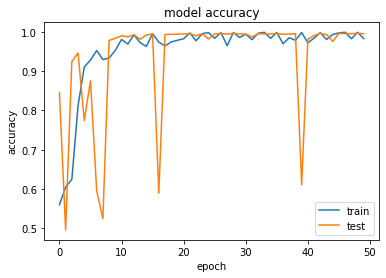

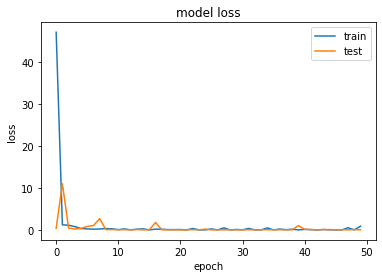

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
JPEG70_MF3_model.evaluate(test_x, test_labels_one_hot)

251/251 [==============================] - 2s 10ms/step - loss: 0.0258 - accuracy: 0.9949


[0.025842010974884033, 0.9948928952217102]

In [ ]:
JPEG70_MF3_model.save('/mnt/drive2/msc_2020/Convlutional Neural Network/models/JPEG70_MF3_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /mnt/drive2/msc_2020/Convlutional Neural Network/models/JPEG70_MF3_model/assets


In [ ]:
JPEG70_MF3_model = load_model('/mnt/drive2/msc_2020/Convlutional Neural Network/models/JPEG70_MF3_model', compile=True)

Positive


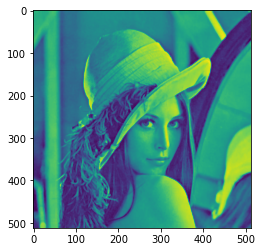

In [ ]:
# Manual Prediction

os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')

I = cv2.imread('Lena.jpeg', 0)
np.clip(I, 0, 255, out=I)
I.astype('uint8')
# I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I
I = I[256-32:256+32, 256-32:256+32]
I = I.reshape(1, 64, 64, 1)


plt.imshow(cv2.medianBlur(cv2.imread('Lena.jpeg', cv2.IMREAD_GRAYSCALE ), 3))
if (JPEG70_MF3_model.predict(I))[0][0] == 0:
    print('Positive')
else:
    print('Negative')

In [ ]:
I = cv2.imread('ucid00001.tif', 0)
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I_rotate = cv2.rotate(I, cv2.ROTATE_90_CLOCKWISE)
plt.subplot(131)
plt.imshow(I)

plt.subplot(132)
plt.imshow(I_rotate)

plt.subplot(133)
I = I.T
plt.imshow(I)

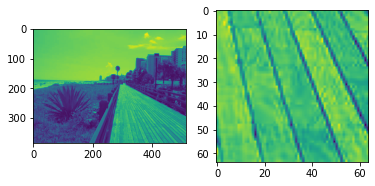

In [ ]:
os.chdir('/mnt/drive2/msc_2020/ucid.v2/images')

I = cv2.imread('ucid01331.jpeg', 0)
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I_crop = crop(I, 5)
plt.subplot(121)
plt.imshow(I)
plt.subplot(122)
plt.imshow(I_crop)

In [ ]:
os.chdir('/mnt/drive2/msc_2020/ucid.v2')
count1=0;count2=0
for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.tif'
    I = cv2.imread(name, 0)
    if I.shape == (384, 512):
        count1 += 1
    elif I.shape == (512, 384):
        count2 += 1

print(count1, count2, count1+count2)

885 453 1338


In [ ]:
data_x.shape

(16056, 64, 64, 1)

In [ ]:
data_y.shape

(16056, 1)

In [ ]:

print(data_x.shape, data_y.shape)

(16056, 64, 64, 1) (16056, 1)


In [ ]:
for i in range(1, 1339):
    img = 'ucid'+(str(i).zfill(5))+'.tif'
    I = Image.open(img)
    name, ext = img.split('.')
    image_70 = os.path.join(f'./images/{name}.jpeg')
    I.save(image_70,"JPEG", quality=70)